In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from typing import List, Tuple, Dict, Sequence, Union
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string
import re





In [3]:
pd.options.display.max_rows=75
pd.options.display.max_columns=100


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\senth\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [11]:
import os
print(os.getcwd())  # This prints the current working directory


c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset


In [12]:
train_df = pd.read_csv(r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\train.tsv", sep='\t', names=column_names)
test_df = pd.read_csv(r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\test.tsv", sep='\t', names=column_names)
valid_df = pd.read_csv(r"c:\Users\senth\Desktop\GITHUB\IEEE\liar_dataset\valid.tsv", sep='\t', names=column_names)


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             10240 non-null  object 
 1   label          10240 non-null  object 
 2   statement      10240 non-null  object 
 3   subject        10238 non-null  object 
 4   speaker        10238 non-null  object 
 5   speaker_job    7342 non-null   object 
 6   state          8030 non-null   object 
 7   party          10238 non-null  object 
 8   barely_true    10238 non-null  float64
 9   false          10238 non-null  float64
 10  half_true      10238 non-null  float64
 11  mostly_true    10238 non-null  float64
 12  pants_on_fire  10238 non-null  float64
 13  context        10138 non-null  object 
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [14]:
train_df.sample(2)

,id,label,statement,subject,speaker,speaker_job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
1684,9719.json,half-true,"In the do-nothing Senate, there are 352 House ...","congress,congressional-rules",lynn-jenkins,U.S. House of Representatives,Kansas,republican,0.0,0.0,1.0,0.0,0.0,a press conference
892,1186.json,pants-fire,"Photo of ""tea party"" protests shows crowd spra...",history,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,conservative blogs


In [15]:
train_df.duplicated().sum()

0

Dataset Overview: 10,240 entries, 14 columns, fact-checking data.
No Duplicates: train_df.duplicated().sum() = 0, ensuring clean data.
Missing Values:
speaker_job (28% missing), state (21.5% missing), context (1% missing).
Data Types:
Categorical: label, statement, subject, speaker, party, etc.
Numerical: barely_true, false, half_true, etc.

In [16]:
def missing_values(data: pd.DataFrame):
    missing_counts = data.isnull().sum()
    missing_percentages = (missing_counts / len(data)) * 100
    missing_data = pd.DataFrame({
        'Missing Count': missing_counts,
        'Percentage': missing_percentages
    })
    
    missing_data = missing_data[missing_data['Missing Count'] > 0]
    
    if not missing_data.empty:
        return missing_data
    else:
        print("No missing values found in the dataset")
        return False


In [18]:
# count of missing values in each column
missing_values_cols  = missing_values(train_df)
missing_values_cols

,Missing Count,Percentage
subject,2,0.019531
speaker,2,0.019531
speaker_job,2898,28.300781
state,2210,21.582031
party,2,0.019531
barely_true,2,0.019531
false,2,0.019531
half_true,2,0.019531
mostly_true,2,0.019531
pants_on_fire,2,0.019531


In [19]:
# filter the rows with missing values and columns based on missing_values_cols
train_df[missing_values_cols.index.values.tolist()].sample(5)

,subject,speaker,speaker_job,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
1923,"women,workers",tim-kaine,U.S. Senator,Virginia,democrat,8.0,3.0,15.0,15.0,0.0,a fundraising letter.
4790,taxes,declan-oscanlon,State Assemblyman,New Jersey,republican,0.0,0.0,0.0,0.0,0.0,an opinion piece in the Star-Ledger
3311,"education,health-care,public-safety,state-budg...",jefferson-smith,state representative,Oregon,democrat,1.0,1.0,0.0,4.0,0.0,a candidates' forum.
8829,"foreign-policy,nuclear",mitt-romney,Former governor,Massachusetts,republican,34.0,32.0,58.0,33.0,19.0,"the third presidential debate in Boca Raton, Fla."
2016,"labor,state-budget",scott-walker,Milwaukee County Executive,Wisconsin,republican,26.0,41.0,32.0,40.0,11.0,a secretly-recorded prank telephone call


High Missing Data:

speaker_job (28.3%) and state (21.58%) may impact demographic insights.
context (0.99%) missing but manageable.
Minimal Impact on Truth Labels:

barely_true, false, half_true, mostly_true, pants_on_fire missing in only 0.02% of cases.

In [23]:
import pandas as pd
from typing import Tuple

def profile_dataset(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    '''
    Analyzes the dataset and returns summaries for numerical and non-numerical columns.

    Parameters:
    df (pd.DataFrame): Input DataFrame

    Returns:
    Tuple[pd.DataFrame, pd.DataFrame]: Numerical and Non-Numerical Summaries
    '''
    
    # Separate numerical and non-numerical columns
    num_df = df.select_dtypes(exclude='object')
    non_num_df = df.select_dtypes(include='object')

    # Helper functions for analysis
    nuniq = lambda data, col: data[col].nunique()
    missing_pct = lambda data, col: (data[col].isnull().sum() / data.shape[0]) * 100
    mode = lambda data, col: data[col].mode().tolist()
    top_five = lambda data, col: data[col].value_counts().head(5).index.tolist()

    # Numerical Summary
    num_summary = num_df.describe().T
    num_summary['unique'] = [nuniq(num_df, col) for col in num_df.columns]
    num_summary['missing_pct'] = [missing_pct(num_df, col) for col in num_df.columns]
    num_summary['top'] = [mode(num_df, col) for col in num_df.columns]
    num_summary['top_five'] = [top_five(num_df, col) for col in num_df.columns]
    num_summary['dtype'] = num_df.dtypes

    # Non-Numerical Summary
    non_num_summary = non_num_df.describe().T
    non_num_summary['missing_pct'] = [missing_pct(non_num_df, col) for col in non_num_df.columns]
    non_num_summary['top_five'] = [top_five(non_num_df, col) for col in non_num_df.columns]

    return num_summary, non_num_summary


In [24]:
numerical_summary, non_numerical_summary = profile_dataset(liar_df)

# Display the summaries
print("\nNumerical Summary:\n", numerical_summary)
print("\nNon-Numerical Summary:\n", non_numerical_summary)



Numerical Summary:
                  count       mean        std  min  25%  50%   75%    max  \
barely_true    12789.0  11.583939  18.978037  0.0  0.0  2.0  12.0   70.0   
false          12789.0  13.359059  24.140086  0.0  0.0  2.0  15.0  114.0   
half_true      12789.0  17.185785  35.847678  0.0  0.0  3.0  13.0  160.0   
mostly_true    12789.0  16.497850  36.165276  0.0  0.0  3.0  12.0  163.0   
pants_on_fire  12789.0   6.251388  16.180777  0.0  0.0  1.0   5.0  105.0   

               unique  missing_pct    top                    top_five    dtype  
barely_true        30     0.015636  [0.0]  [0.0, 1.0, 2.0, 3.0, 70.0]  float64  
false              30     0.015636  [0.0]  [0.0, 1.0, 2.0, 5.0, 71.0]  float64  
half_true          29     0.015636  [0.0]   [0.0, 1.0, 2.0, 3.0, 4.0]  float64  
mostly_true        27     0.015636  [0.0]   [0.0, 1.0, 2.0, 5.0, 4.0]  float64  
pants_on_fire      20     0.015636  [0.0]   [0.0, 1.0, 3.0, 9.0, 2.0]  float64  

Non-Numerical Summary:
            

In [25]:
numerical_summary

,count,mean,std,min,25%,50%,75%,max,unique,missing_pct,top,top_five,dtype
barely_true,12789.0,11.583939,18.978037,0.0,0.0,2.0,12.0,70.0,30,0.015636,[0.0],"[0.0, 1.0, 2.0, 3.0, 70.0]",float64
false,12789.0,13.359059,24.140086,0.0,0.0,2.0,15.0,114.0,30,0.015636,[0.0],"[0.0, 1.0, 2.0, 5.0, 71.0]",float64
half_true,12789.0,17.185785,35.847678,0.0,0.0,3.0,13.0,160.0,29,0.015636,[0.0],"[0.0, 1.0, 2.0, 3.0, 4.0]",float64
mostly_true,12789.0,16.497850,36.165276,0.0,0.0,3.0,12.0,163.0,27,0.015636,[0.0],"[0.0, 1.0, 2.0, 5.0, 4.0]",float64
pants_on_fire,12789.0,6.251388,16.180777,0.0,0.0,1.0,5.0,105.0,20,0.015636,[0.0],"[0.0, 1.0, 3.0, 9.0, 2.0]",float64


In [31]:
print(liar_df.columns)


Index(['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job',
       'state', 'party', 'barely_true', 'false', 'half_true', 'mostly_true',
       'pants_on_fire', 'context'],
      dtype='object')


In [32]:
numerical_columns_df = liar_df[["barely_true", "false", "half_true", 
                                "mostly_true", "pants_on_fire", "label"]]

print(numerical_columns_df.head())  # Check the extracted data


   barely_true  false  half_true  mostly_true  pants_on_fire        label
0          0.0    1.0        0.0          0.0            0.0        false
1          0.0    0.0        1.0          1.0            0.0    half-true
2         70.0   71.0      160.0        163.0            9.0  mostly-true
3          7.0   19.0        3.0          5.0           44.0        false
4         15.0    9.0       20.0         19.0            2.0    half-true


In [33]:
numerical_columns_df.sample(10)

,barely_true,false,half_true,mostly_true,pants_on_fire,label
9242,1.0,1.0,0.0,1.0,0.0,false
4776,5.0,5.0,11.0,8.0,3.0,half-true
3517,40.0,29.0,69.0,76.0,7.0,true
3073,1.0,1.0,0.0,2.0,1.0,false
11815,6.0,9.0,3.0,1.0,4.0,true
9519,0.0,2.0,1.0,1.0,1.0,false
272,31.0,39.0,31.0,37.0,8.0,half-true
9623,0.0,1.0,1.0,1.0,2.0,false
6616,0.0,1.0,0.0,0.0,0.0,false
3226,70.0,71.0,160.0,163.0,9.0,mostly-true


In [34]:
numerical_columns_df[numerical_columns_df['label']==5]

,barely_true,false,half_true,mostly_true,pants_on_fire,label


In [35]:
numerical_columns_df.describe()

,barely_true,false,half_true,mostly_true,pants_on_fire
count,12789.000000,12789.000000,12789.000000,12789.000000,12789.000000
mean,11.583939,13.359059,17.185785,16.497850,6.251388
std,18.978037,24.140086,35.847678,36.165276,16.180777
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,2.000000,3.000000,3.000000,1.000000
75%,12.000000,15.000000,13.000000,12.000000,5.000000
max,70.000000,114.000000,160.000000,163.000000,105.000000


In [37]:
numerical_features = [feature for feature in numerical_columns_df.columns]

discrete_feature=[feature for feature in numerical_features if len(train_df[feature].unique())<10]
print("Discrete Variables Count: {}".format(len(discrete_feature)))

continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature]
print("Continuous feature Count {}".format(len(continuous_feature)))


Discrete Variables Count: 1
Continuous feature Count 5


In [38]:
print('Discrete Variables')
train_df[discrete_feature].head()

Discrete Variables


,label
0,false
1,half-true
2,mostly-true
3,false
4,half-true


In [39]:
print('Continuous Variables')
train_df[continuous_feature].head()

Continuous Variables


,barely_true,false,half_true,mostly_true,pants_on_fire
0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0
2,70.0,71.0,160.0,163.0,9.0
3,7.0,19.0,3.0,5.0,44.0
4,15.0,9.0,20.0,19.0,2.0


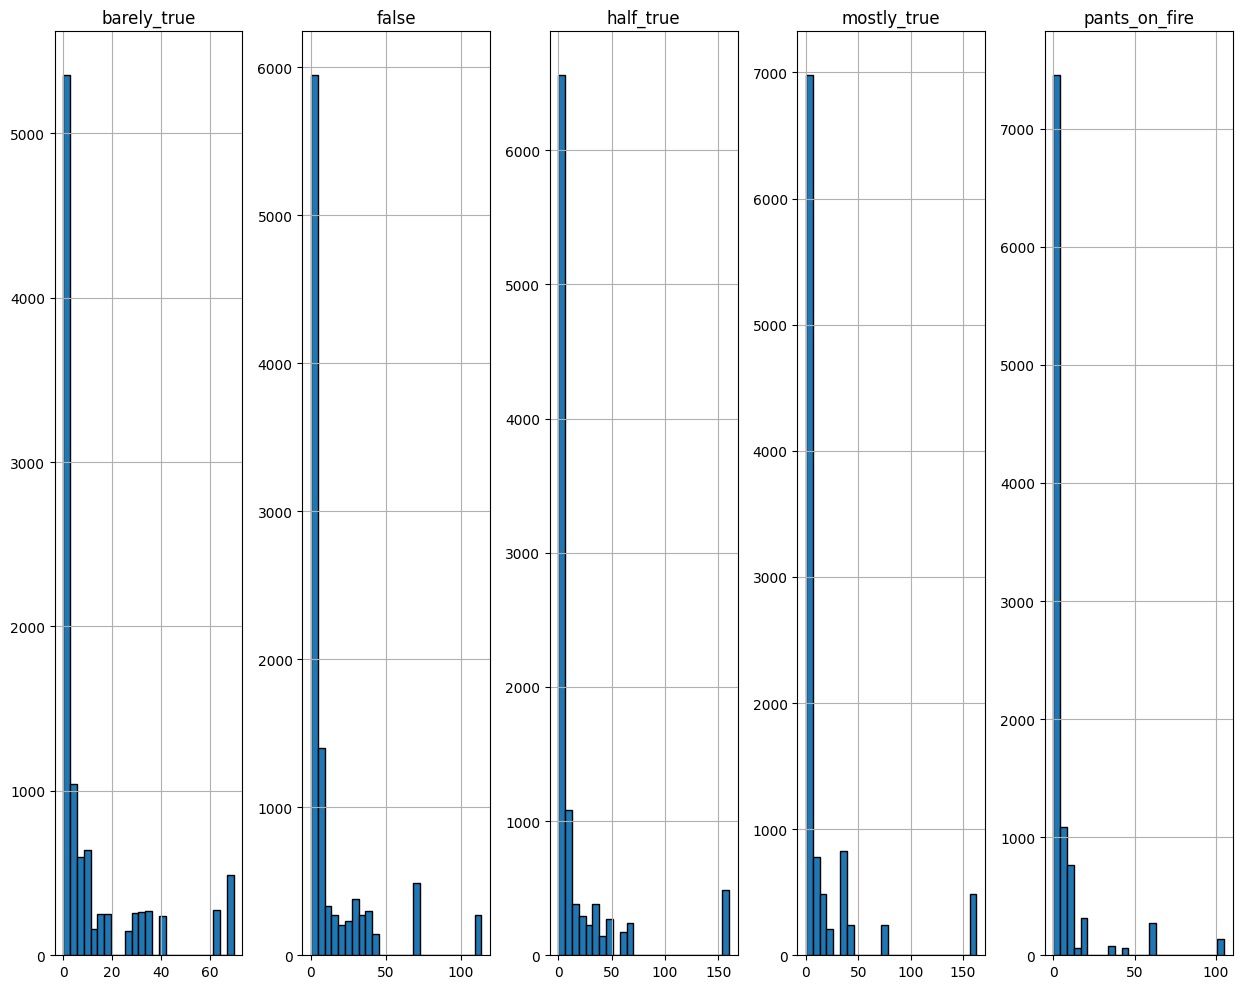

In [40]:
train_df[continuous_feature].hist(bins=25, figsize=(15, 10), layout=(-1, 6), edgecolor="black")
plt.tight_layout()

In [41]:
# non numerical columns summary
non_numerical_summary

,count,unique,top,freq,missing_pct,top_five
id,12791,12791,2635.json,1,0.000000,"[2635.json, 1680.json, 8964.json, 11484.json, ..."
label,12791,6,half-true,2627,0.000000,"[half-true, false, mostly-true, barely-true, t..."
statement,12791,12765,On a cap-and-trade plan.,3,0.000000,"[On a cap-and-trade plan., On changing the rul..."
subject,12789,4534,health-care,474,0.015636,"[health-care, taxes, education, elections, imm..."
speaker,12789,3309,barack-obama,611,0.015636,"[barack-obama, donald-trump, hillary-clinton, ..."
speaker_job,9223,1354,President,615,27.894613,"[President, U.S. Senator, Governor, President-..."
state,10040,84,Texas,1260,21.507310,"[Texas, Florida, Wisconsin, New York, Illinois]"
party,12789,24,republican,5665,0.015636,"[republican, democrat, none, organization, ind..."
context,12660,5142,a news release,309,1.024158,"[a news release, an interview, a press release..."


In [45]:
non_numerical_columns_df = liar_df[["speaker", "speaker_job", "statement", 
                                    "subject", "context", "state", "party"]]




In [46]:
non_numerical_columns_df.sample(5)

,speaker,speaker_job,statement,subject,context,state,party
10012,jim-mcdermott,U.S. Representative,"During the Bush administration, liberal groups...","bush-administration,taxes",a House Ways and Means hearing,Washington state,democrat
4730,mary-burke,Madison school board member,Youve seen where were now going from a $700 mi...,"state-budget,state-finances",an interview,Wisconsin,democrat
7465,barack-obama,President,I lowered taxes over the last two years.,taxes,an interview on Super Bowl Sunday,Illinois,democrat
597,scott-walker,Milwaukee County Executive,On repeal of Wisconsins smoking ban,public-health,a news release,Wisconsin,republican
2577,rick-santorum,NaN,"Romneycare is a top-down, government-run healt...",health-care,a Republican presidential primary debate,Pennsylvania,republican


In [51]:

def clean_data(text: str ,lower_case = False, allow_digits = True, allow_special_chars = False, allow_punctuations = True)->str:
    text = str(text)
    if lower_case:
        text = text.lower()
    text = re.sub("'s", "", text)
    text = re.sub("'ve", "", text)
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)  # Remove duplicate words
    text = re.sub(r'([\d]+)', r' \1 ', text)
    text = re.sub(r'([.,-/!&*@#\/()])', r' \1 ', text)
    text = re.sub(r'(.)\1{2,}', r'\1\1', text)  # Limit repeated characters
    
    if allow_digits:
        text = re.sub(r'[^a-zA-Z0-9.,_()$\-\'/ ]', '', text)
    else:
        text = re.sub(r'[^a-zA-Z_().,$\-\'/ ]', '', text)
    
    if not allow_special_chars:
        text = re.sub(r'[_()$\+\-\'/]', '', text)
    if not allow_punctuations:
        text = re.sub(r'[.,!:;]', '', text)
    
    text = re.sub(' +', ' ', text).strip()  # Remove multiple spaces and trim
    return text

def preprocess_text(text):
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    words = [lemmatizer.lemmatize(word) for word in words]
    return " ".join(words)

def univariate_text_analysis(data: pd.DataFrame, text_column: str):
    if text_column not in data.columns:
        raise ValueError(f"Column '{text_column}' not found in DataFrame")
    
    data[text_column] = data[text_column].apply(lambda x: clean_data(x, lower_case=True, allow_digits=False, allow_special_chars=False, allow_punctuations=False))
    data[text_column] = data[text_column].apply(preprocess_text)
    text_data = data[text_column].dropna()
    
    unique_values = text_data.nunique()
    top_values = text_data.value_counts().head(10)
    all_words = " ".join(text_data.astype(str)).split()
    word_counts = Counter(all_words)
    most_common_words = word_counts.most_common(10)
    text_lengths = text_data.astype(str).apply(len)
    
    print(f"Total Unique Values: {unique_values}")
    print("\nTop 10 Most Frequent Text Entries:\n", top_values)
    print("\nMost Common Words:\n", most_common_words)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    words, counts = zip(*most_common_words)
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.xlabel("Count")
    plt.title("Top 10 Most Frequent Words")
    
    plt.subplot(1, 2, 2)
    sns.histplot(text_lengths, bins=20, kde=True, color="skyblue")
    plt.xlabel("Text Length")
    plt.title("Distribution of Text Lengths")
    plt.tight_layout()
    plt.show()
    
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Word Cloud of Text Data")
    plt.show()

In [52]:
clean_data("this is a test 1234", lower_case=True, allow_digits=False, allow_special_chars=False, allow_punctuations=False)

'this is a test'

In [55]:
non_numerical_columns_df.columns

Index(['speaker', 'speaker_job', 'statement', 'subject', 'context', 'state',
       'party'],
      dtype='object')

Numerical Data:
12,789 entries across five numerical columns.
Mean values range from 6.25 (pants_on_fire) to 17.18 (half_true).
High variance in half_true (35.85) and mostly_true (36.16).
Most frequent value: 0 in all categories.
Minimal missing values (0.015%).

Non-Numerical Data:
Labels: Six categories, most frequent is half-true (2,627).
Subjects & Speakers: Common topics include healthcare, Barack Obama.
State & Speaker Job: Missing values (21.5% and 27.8%), Texas and President are most frequent.
Party: Dominated by Republican & Democrat.

<Axes: xlabel='state'>

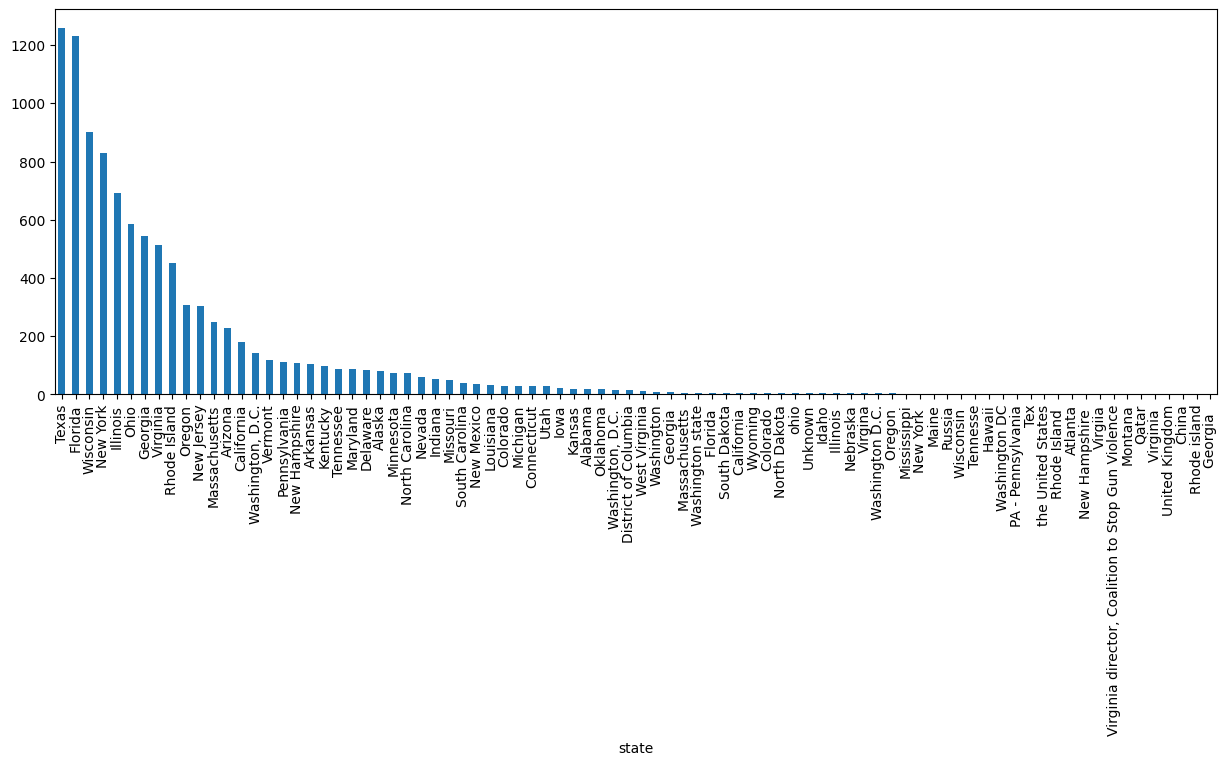

In [57]:
# state_info column
non_numerical_columns_df['state'].value_counts().plot(kind='bar', figsize=(15, 5))

Column: speaker
Unique values: 2909
speaker
barack obama       488
donald trump       273
hillary clinton    239
mitt romney        176
scott walker       149
john mccain        148
chain email        142
rick perry         142
marco rubio        117
rick scott         115
Name: count, dtype: int64


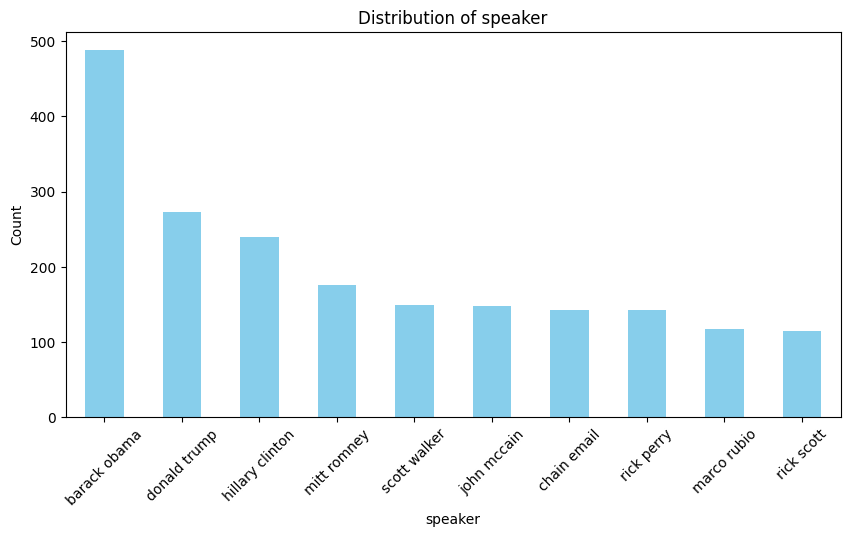

Column: subject
Unique values: 3827
subject
health-care             381
taxes                   308
immigration             253
elections               252
education               237
candidates-biography    190
economy                 137
guns                    130
economy,jobs            125
federal-budget          121
Name: count, dtype: int64


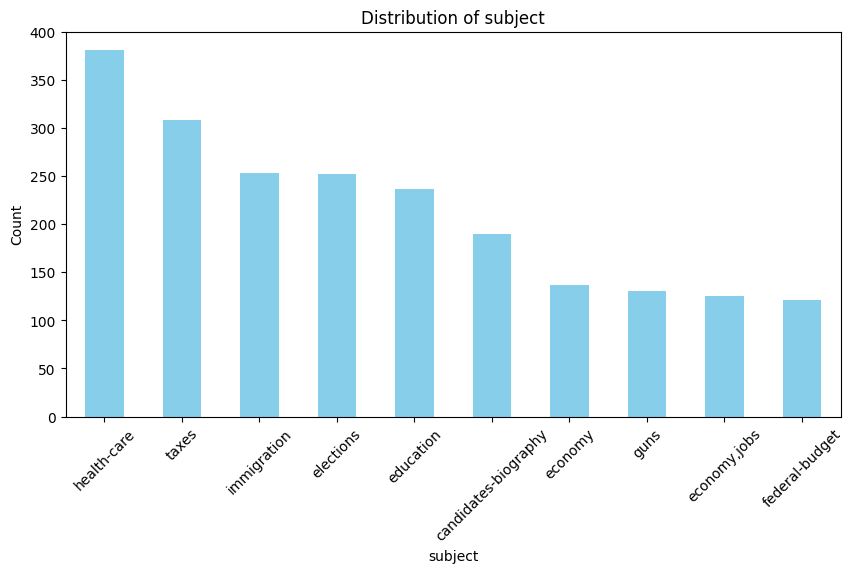

Column: context
Unique values: 4345
context
a news release       241
an interview         229
a press release      223
a speech             214
a TV ad              180
a tweet              156
a campaign ad        132
a television ad      123
a radio interview    106
a debate              92
Name: count, dtype: int64


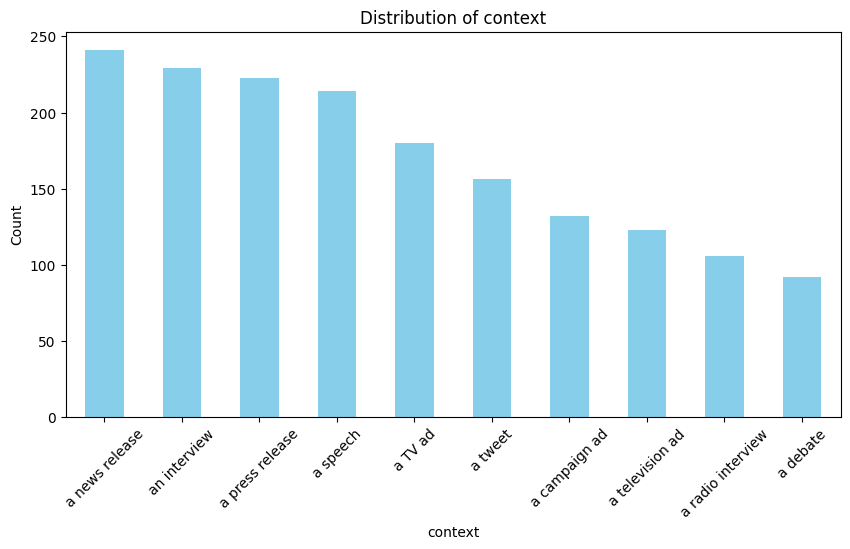

In [67]:
import pandas as pd
import matplotlib.pyplot as plt


# List of non-numeric columns (modify based on your dataset)
non_numeric_cols = ['speaker', 'speaker_description', 'subject', 'party_affiliation', 'context']  # Add more if needed

# Function for univariate analysis
def univariate_analysis(data, column):
    print(f"Column: {column}")
    print("Unique values:", data[column].nunique())  # Count of unique categories
    print(data[column].value_counts().head(10))  # Show top 10 most frequent values
    
    # Plot bar chart
    plt.figure(figsize=(10, 5))
    data[column].value_counts().head(10).plot(kind='bar', color='skyblue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()
    
# Apply analysis to each non-numeric column
for col in non_numeric_cols:
    if col in train_df.columns:
        univariate_analysis(train_df, col)
